<a href="https://colab.research.google.com/github/BenGreenleaf/IA-IB-Google-Colab-Investigations/blob/main/Propulsion_Investigation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-965599679.py:36: UserWarning: ChemEquil::equilibrate: Temperature (3002.1530523833594 K) outside valid range of 300 K to 3000 K
  gas.equilibrate("HP")
/tmp/ipython-input-965599679.py:36: UserWarning: ChemEquil::equilibrate: Temperature (3009.732081802866 K) outside valid range of 300 K to 3000 K
  gas.equilibrate("HP")


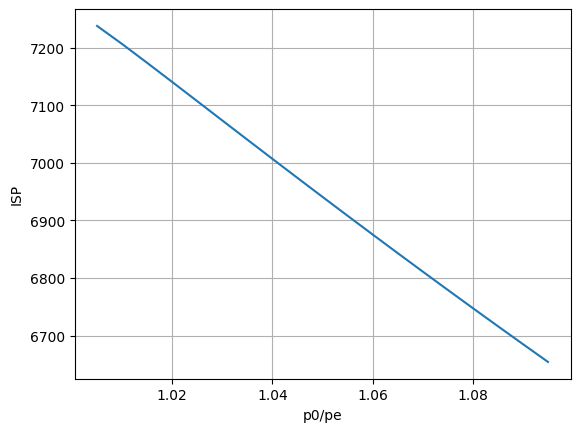

In [ ]:
import cantera as ct
import math
import matplotlib.pyplot as plt
import numpy as np

gas = ct.Solution("gri30.yaml")

#variables:
#ae_at_ratio, pe, p0, phi

Ae_At_ratio = 30

data = [[],[],[],[],[]] #p0, pe, phi_optimum, isp

for p_ratio in range(1,20):
  p_ratio = (1) + (p_ratio/200)
  best_curr_data = [0, 0, 0, 0] #p0, pe, phi_optimum, isp
  for j in range(2,15):
    # --- USER INPUTS ---
    p0 = j * ct.one_atm       # chamber (stagnation) pressure [Pa]
    pe = (1/p_ratio) * p0       # exit static pressure [Pa] (set to ambient if testing)
    nozzle_eta = 1.0         # nozzle efficiency (0-1) to account for losses
    g0 = 9.80665  # m/s^2


    phis = []
    thrusts = []
    ve_list = []
    mdot_list = []
    isp_list = []

    for i in range(1, 100):   # phi from 0.1 to 1.9
        phi = i/10.
        # 1) set fresh initial state at chamber conditions each loop
        gas.TP = 298.0, p0
        gas.set_equivalence_ratio(phi=phi, fuel="H2", oxidizer="O2:1")

        # 2) equilibrium at HP -> adiabatic flame at chamber pressure
        gas.equilibrate("HP")

        T0 = gas.T        # stagnation (chamber) temperature
        h0 = gas.h        # J/kg
        s0 = gas.s
        mw = gas.mean_molecular_weight  # kg/kmol
        R = ct.gas_constant / mw        # J/kg-K

        # mixture gamma at stagnation (approx)
        gamma = gas.cp_mass / gas.cv_mass

        # 3) isentropic expansion to exit pressure (static) -> gives exit enthalpy
        gas.SP = s0, pe
        he = gas.h

        # 4) exhaust velocity (ideal) with nozzle efficiency
        delta_h = h0 - he
        if delta_h <= 0:
            v_e = 0.0
        else:
            v_e = math.sqrt(2.0 * nozzle_eta * delta_h)

        # 5A) If you already know mass flow (mdot_known), you can skip 5B and compute thrust = mdot_known * v_e

        # 5B) Compute mdot by choked throat formula (approx) using gamma, R, T0, p0
        # choked mass flux factor:
        choke_factor = ( (2.0/(gamma+1.0)) ** ((gamma+1.0)/(2.0*(gamma-1.0))) )
        mdot =  p0 * math.sqrt(gamma / (R * T0)) * choke_factor

        thrust = (mdot * v_e) + (pe-ct.one_atm)*(Ae_At_ratio) #thrust, isp at atmosphere
        Isp = thrust / (mdot * g0)

        phis.append(phi)
        thrusts.append(thrust)
        ve_list.append(v_e)
        mdot_list.append(mdot)
        isp_list.append(Isp)

    best_phi = phis[np.argmax(isp_list)]
    if isp_list[np.argmax(isp_list)] > best_curr_data[3]:
      best_curr_data = [p0, pe, best_phi, isp_list[np.argmax(isp_list)]]

  data[0].append(best_curr_data[0])
  data[1].append(best_curr_data[1])
  data[2].append(best_curr_data[2])
  data[3].append(best_curr_data[3])
  data[4].append(best_curr_data[0]/best_curr_data[1])

  '''# Plot example: Thrust vs phi
  plt.plot(phis, isp_list)
  plt.xlabel("Equivalence ratio φ")
  plt.ylabel("ISP")
  plt.grid(True)
  plt.show()'''

plt.plot(data[4], data[3])
plt.xlabel("p0/pe")
plt.ylabel("ISP")
plt.grid(True)
plt.show()



In [ ]:
import cantera as ct

# Re-initialize the gas object to ensure a clean state for the calculation
gas = ct.Solution("gri30.yaml")
gas.TP = 298, ct.one_atm

# Define the target pressure for expansion
pe = ct.one_atm

# Store initial enthalpy and entropy
h_initial = gas.h
s_initial = gas.s

# Expand isentropically to the target pressure 'pe'
# The 'SP' argument means constant entropy (s_initial) and constant pressure (pe)
gas.SP = s_initial, pe

# Get the final enthalpy after isentropic expansion
h_final = gas.h

# Calculate the change in enthalpy
delta_h = h_final - h_initial

print(f"Initial Enthalpy: {h_initial:.2f} J/kg")
print(f"Initial Entropy: {s_initial:.2f} J/kg-K")
print(f"Final Enthalpy (after isentropic expansion): {h_final:.2f} J/kg")
print(f"Change in Enthalpy (Δh): {delta_h:.2f} J/kg")

THEORY

$2H_{2}+O_{2}→2H_{2}O$

For $\phi > 1$, we are running rich so the formula becomes:
$2\phi H_{2}+O_{2}→2H_{2}O+2(\phi -1)H_{2}$

For $\phi < 1$, we are running lean so the formula becomes:
$2\phi H_{2}+O_{2}→2\phi H_{2}O+(1-\phi)O_{2}$
